# Tutorial 4 - Matching
We will use the Lalonde data set, which records the effect of enrollment in a job training on income. \
The data was downloaded from the R package, designmatch. \
See https://search.r-project.org/CRAN/refmans/designmatch/html/lalonde.html \
For more information about the trial, see https://www.jstor.org/stable/1806062 \


In [3]:
%pip install tableone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00


In [1]:

from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from tableone import TableOne
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
data = pd.read_csv('sampled_infant_mortality_data_imputed_m1.csv')

In [3]:
# view data
data.head()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_3,DPLURAL_4,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9
0,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,31.312562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,47.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,31.312562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# check for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123358 entries, 0 to 123357
Columns: 243 entries, FAGECOMB to SETORDER_R_9
dtypes: float64(62), int64(181)
memory usage: 228.7 MB


In [5]:
# get a feel for distribution
data.describe()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_3,DPLURAL_4,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9
count,123358.000000,123358.00000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,...,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000,123358.000000
mean,31.312562,0.01019,0.051549,0.019139,0.056243,0.003218,0.036382,0.019115,0.008544,0.992931,...,0.002083,0.000340,0.000049,0.016513,0.026135,0.026962,0.000835,0.000073,0.000016,0.929465
std,6.348513,0.10043,0.221116,0.137016,0.230391,0.056639,0.187239,0.136930,0.092040,0.083779,...,0.045597,0.018449,0.006974,0.127438,0.159538,0.161974,0.028884,0.008541,0.004027,0.256047
min,13.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,31.312562,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,34.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,82.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
data['T'].value_counts()

,count
T,
1.0,95733
0.0,27625


#### We will try to understand the effect of enrollment in the program (treatment = 1) on the participants' revenue in 1978
We assume SUTVA, conditional independence (exchangeability) and consistency.

In [3]:
# Split the data into features (X), treatment (T) and target (y)
T = data['T']
y = data['Y']
X = data.drop(columns=['T', 'Y'])

In [4]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

In [5]:
# Split the data into training and testing sets
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [6]:
# I chose to use logistic regression + CV because this is a small dataset
propensity_model = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
# fit model
propensity_model.fit(X_train, T_train)
# Predict probabilities on the test set
T_prob_train = propensity_model.predict_proba(X_train)[:,1]
T_prob_test = propensity_model.predict_proba(X_test)[:,1] # Probabilities for the positive class

In [11]:
# Brier score, 0 is the perfect score
brier_score = brier_score_loss(T_test, T_prob_test)
print(f'Brier Score: {brier_score}')

Brier Score: 0.1385622181461416


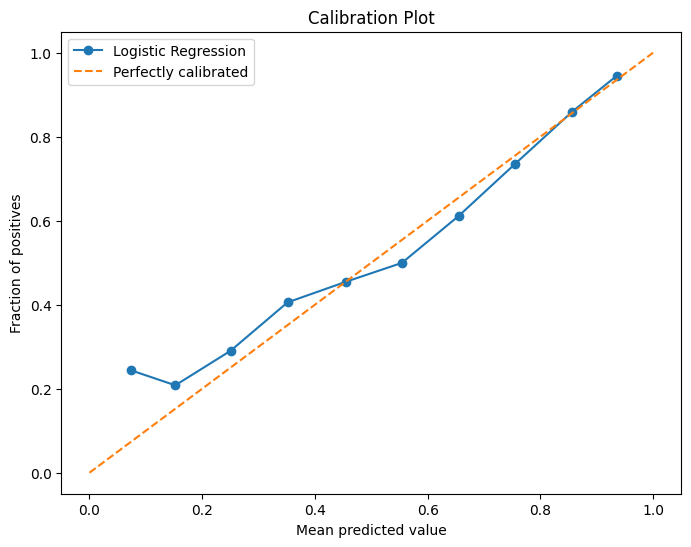

In [12]:
# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, T_prob_test, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

Check overlap (positivity) on train set

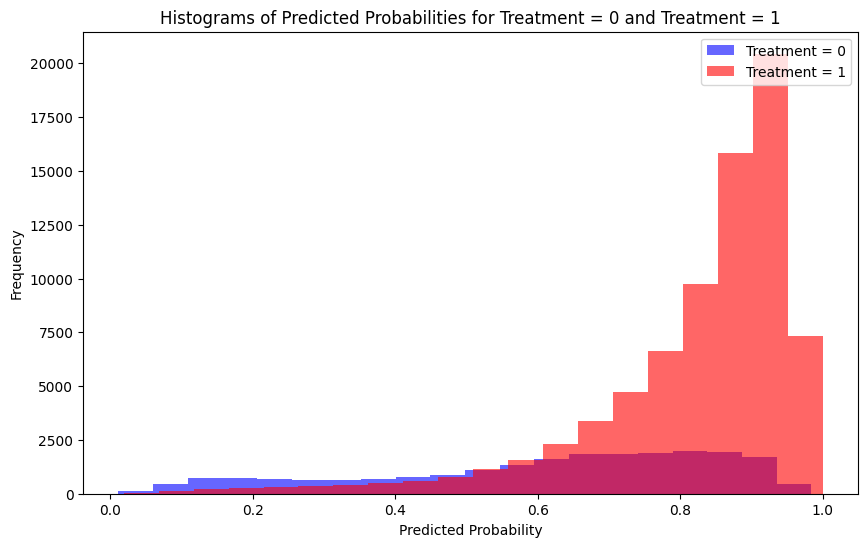

In [13]:
# Plot histograms for treatment=0 and treatment=1

# Separate the probabilities for treatment = 0 and treatment = 1
prob_treatment_0 = T_prob_train[T_train == 0]
prob_treatment_1 = T_prob_train[T_train == 1]

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')

# Add labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
plt.legend(loc='upper right')

# Show the plot
plt.show()

Trim data to ensure overlap (set trimming boundaries on train set to avoid data leakage)

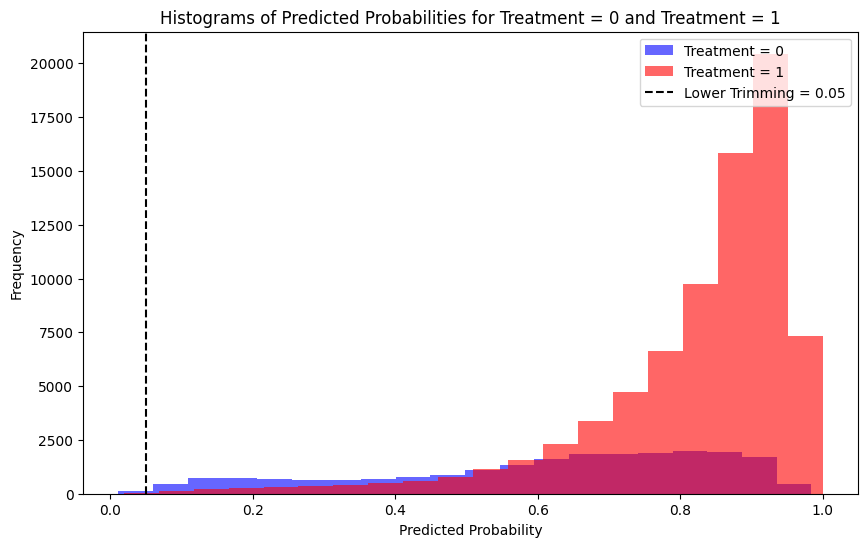

In [14]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')
plt.axvline(x=0.05, color='black', linestyle='--', label='Lower Trimming = 0.05')
# Add labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
plt.legend(loc='upper right')

# Show the plot
plt.show()

we exclude participants whose estimated probability of being included in treatment is too low

In [15]:
# How many reduced in train
print('Participants removed from train set due to lack of overlap: {}'.format(X_train[T_prob_train < 0.05].shape[0]))
print('Participants removed from test set due to lack of overlap: {}'.format(X_test[T_prob_test < 0.05].shape[0]))

Participants removed from train set due to lack of overlap: 80
Participants removed from test set due to lack of overlap: 19


In [7]:
X_train = X_train[T_prob_train >= 0.05]
T_train = T_train[T_prob_train >= 0.05]
y_train = y_train[T_prob_train >= 0.05]
X_test = X_test[T_prob_test >= 0.05]
T_test = T_test[T_prob_test >= 0.05]
y_test = y_test[T_prob_test >= 0.05]

propensity_train_data = pd.concat([X_train, T_train, y_train], axis=1)
propensity_test_data = pd.concat([X_test, T_test, y_test], axis=1)

Now we are ready for causal effect estimation

## Matching

In [8]:
trimmed_data = pd.concat([propensity_train_data, propensity_test_data])

In [10]:
trimmed_data.head()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9,T,Y
117149,0.423319,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
7475,1.210909,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,0.0,1
46373,-1.151859,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
54802,0.895873,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
34390,-0.206752,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,0.0,0


We will look at a pre-matching comparison of the two treatment/intervention groups \
First using what is called a "Table1" because it is usually the first table in medical studies \
Secondly, standardized mean differences can be used to compare variables of different scales. The convention for "acceptable" difference is below 0.1. This is arbitrary like p-values needing to be below 0.05.

In [11]:
all_cols = list(X.columns)
table1 = TableOne(trimmed_data, columns=all_cols, groupby='T', nonnormal=[], pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))

╒══════════════════════╤═════════════════════════╤═══════════╤════════════════╤═══════════════╤═══════════════╤═════════════════╕
│                      │                         │ Missing   │ Overall        │ 0.0           │ 1.0           │ SMD (0.0,1.0)   │
╞══════════════════════╪═════════════════════════╪═══════════╪════════════════╪═══════════════╪═══════════════╪═════════════════╡
│ n                    │                         │           │ 123259         │ 27547         │ 95712         │                 │
├──────────────────────┼─────────────────────────┼───────────┼────────────────┼───────────────┼───────────────┼─────────────────┤
│ FAGECOMB, n (%)      │ -0.04923410758815052    │           │ 6214 (5.0)     │ 1112 (4.0)    │ 5102 (5.3)    │ 0.408           │
├──────────────────────┼─────────────────────────┼───────────┼────────────────┼───────────────┼───────────────┼─────────────────┤
│                      │ -0.2067519516012383     │           │ 6208 (5.0)     │ 1080 (3.9)

In [12]:
table1.smd_table = table1.smd_table[abs(table1.smd_table.values) > 0.25]

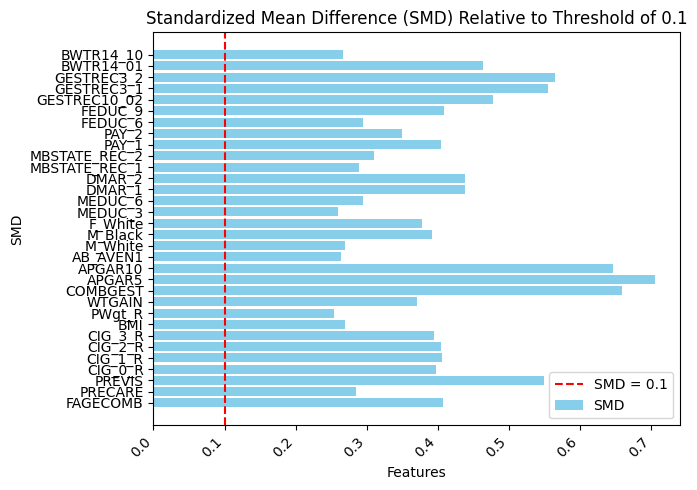

In [13]:
plt.figure(figsize=(7, 5))

plt.barh(table1.smd_table.index, abs(table1.smd_table.values).flatten(), color='skyblue', label='SMD')

# SMD <= 0.1 is the convention for acceptable, like p-value <= 0.05
plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('Features')
plt.ylabel('SMD')
plt.title('Standardized Mean Difference (SMD) Relative to Threshold of 0.1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Moving on to matching

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

We will standardize features and then perform euclidean distance. \
Other matching methodologies include mahanalobis matching, optimal matching, coarse matching (don't do propensity score matching) \
The easiest package to use is in R and is called Matchit...

In [10]:
standard_scaler = StandardScaler().fit(trimmed_data[X.columns])
standardized_data = deepcopy(trimmed_data)
standardized_data[X.columns] = standard_scaler.transform(standardized_data[X.columns])
standardized_data_treat1 = standardized_data.query('T == 1').reset_index().drop(columns=['index'])
standardized_data_treat0 = standardized_data.query('T == 0').reset_index().drop(columns=['index'])

Why is it important to rescale the data?

In [13]:
standardized_data_treat1.head()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9,T,Y
0,0.423082,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
1,-1.151673,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
2,0.895508,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
3,-0.000124,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,7.714277,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,-3.633228,1.0,0
4,-1.624099,-0.101218,4.288297,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0


In [11]:
confounders = X.columns

In [12]:
nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1)
distance, standardized_data_treat1['matched_treat0'] = nn.fit(standardized_data_treat0[confounders]).kneighbors(standardized_data_treat1[confounders])
matched_data = standardized_data_treat1.merge(standardized_data_treat0, left_on='matched_treat0', right_index=True, how='left', suffixes=('_treat1', '_treat0'))

In [16]:
matched_data.head()

,FAGECOMB_treat1,RF_PDIAB_treat1,RF_GDIAB_treat1,RF_PHYPE_treat1,RF_GHYPE_treat1,RF_EHYPE_treat1,RF_PPB_treat1,RF_INFT_treat1,RF_DRG_treat1,RF_ART_treat1,...,DPLURAL_5_treat0,SETORDER_R_ _treat0,SETORDER_R_1_treat0,SETORDER_R_2_treat0,SETORDER_R_3_treat0,SETORDER_R_4_treat0,SETORDER_R_5_treat0,SETORDER_R_9_treat0,T_treat0,Y_treat0
0,0.423082,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
1,-1.151673,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
2,0.895508,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
3,-0.000124,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
4,-1.624099,-0.101218,4.288297,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0


#### Point Estimation of ATT
Why is this ATT, not ATE

In [17]:
np.mean(matched_data['Y_treat1'] - matched_data['Y_treat0'])

np.float64(-0.021731862253426947)

Although we have the point estimate, we need to quantify the level of uncertainty around our estimate.\
Before doing that, we will look compare our features using the Table1 and SMD tables from before.

In [13]:
# put the matching df into the same format as the trimming_data table earlier, which works for TableOne
all_cols = list(confounders)

rename_dict_treat1 = {f"{col}_treat1": col for col in all_cols}
rename_dict_treat0 = {f"{col}_treat0": col for col in all_cols}

treat1 = matched_data.iloc[:, :242].assign(T=1).rename(columns=rename_dict_treat1)
treat0 = matched_data.iloc[:, 243:-1].assign(T=0).rename(columns=rename_dict_treat0)
matching_df_long = pd.concat([treat1, treat0], axis=0)

In [25]:
print(matching_df_long.shape)
small_table = matching_df_long.sample(20000, random_state=42).reset_index(drop=True)

(191424, 245)


In [26]:
table1 = TableOne(small_table, columns=all_cols, groupby='T', nonnormal=[], pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))

╒══════════════════════╤═════════════════════════╤═══════════╤═══════════════╤══════════════╤═══════════════╤═════════════╕
│                      │                         │ Missing   │ Overall       │ 0            │ 1             │ SMD (0,1)   │
╞══════════════════════╪═════════════════════════╪═══════════╪═══════════════╪══════════════╪═══════════════╪═════════════╡
│ n                    │                         │           │ 20000         │ 9988         │ 10012         │             │
├──────────────────────┼─────────────────────────┼───────────┼───────────────┼──────────────┼───────────────┼─────────────┤
│ FAGECOMB, n (%)      │ -0.0001236894410505748  │           │ 2829 (14.1)   │ 1521 (15.2)  │ 1308 (13.1)   │ 0.223       │
├──────────────────────┼─────────────────────────┼───────────┼───────────────┼──────────────┼───────────────┼─────────────┤
│                      │ -0.04934454737734315    │           │ 1032 (5.2)    │ 522 (5.2)    │ 510 (5.1)     │             │
├───────

In [37]:
table1.smd_table = table1.smd_table[abs(table1.smd_table.values) > 0.16]

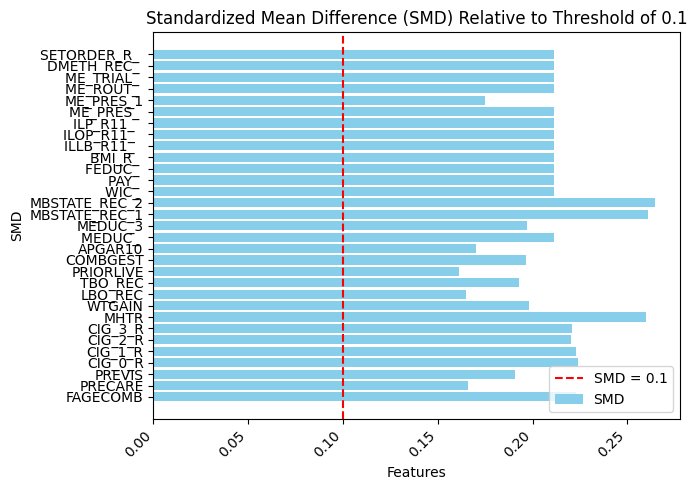

In [38]:
plt.figure(figsize=(7, 5))
plt.barh(table1.smd_table.index, abs(table1.smd_table.values).flatten(), color='skyblue', label='SMD')

# SMD <= 0.1 is the convention for acceptable, like p-value <= 0.05
plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('Features')
plt.ylabel('SMD')
plt.title('Standardized Mean Difference (SMD) Relative to Threshold of 0.1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Did matching resolve in a "new", "balanced" data set?

#### But these tables can be misleading because they do not take into account interactions.
Now the data set is now balanced over no-degree and married, \
but what if for treatment=1 all of the married people have no degree but for treatment=0 all of the married people have a degree? \
Is there overlap? \
It depends on the propensity. Which is why you always need to look at the propensity and you should be careful with tables like these.\
See tutorial

####  Confidence Intervals

This is just one example of creating confidence intervals to give you a feel \
This example is not canonical

In [ ]:
bootstrap_sample_size = 1000
alpha = 0.05
np.random.seed(2025)
att_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(standardized_data.index,
                                         size=standardized_data.shape[0],
                                         replace=True)
    bootstrap_standardized_data = standardized_data.loc[bootstrap_indices]
    standardized_data_treat1 = bootstrap_standardized_data.query('treatment == 1').reset_index().drop(columns=['index'])
    standardized_data_treat0 = bootstrap_standardized_data.query('treatment == 0').reset_index().drop(columns=['index'])
    nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1)
    distance, standardized_data_treat1['matched_treat0'] = nn.fit(standardized_data_treat0[confounders]).kneighbors(standardized_data_treat1[confounders])
    matched_data = standardized_data_treat1.merge(standardized_data_treat0, left_on='matched_treat0', right_index=True, how='left', suffixes=('_treat1', '_treat0'))
    att_estimate = np.mean(matched_data['re78_treat1'] - matched_data['re78_treat0'])
    att_estimates.append(att_estimate)

# Convert the list of estimates into a numpy array
matching_bootstrap_estimates = np.array(att_estimates)

# Calculate the lower and upper percentiles to get the CI
matching_ci = np.percentile(matching_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {matching_ci[0]}, Upper = {matching_ci[1]}")

95% Confidence Interval: Lower = -1155.4302672937501, Upper = 3227.0143239457275


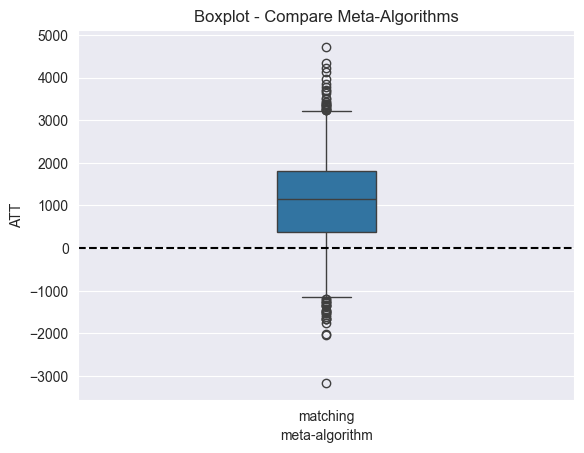

In [ ]:
df = pd.DataFrame({'matching': matching_bootstrap_estimates}).melt()
df.columns = ['meta-algorithm', 'ATT']
sns.boxplot(x='meta-algorithm', y='ATT', data=df, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

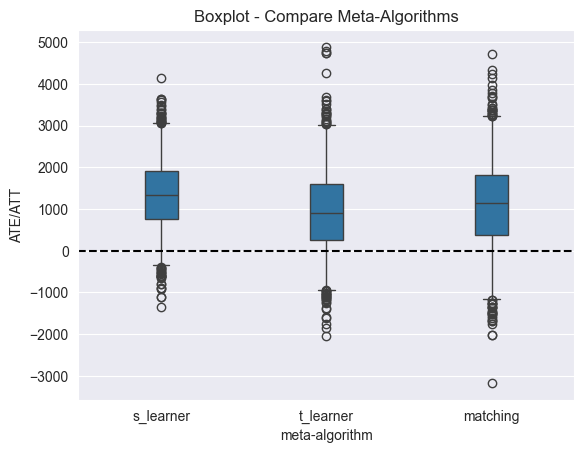

In [ ]:
# We will compare with what we found last week
import joblib
bootstrap_dict = joblib.load('de_bootstrap_estimates.pkl')
bootstrap_dict['matching'] = matching_bootstrap_estimates
joblib.dump(bootstrap_dict, 'de_matching_bootstrap_estimates.pkl')

df = pd.DataFrame(bootstrap_dict).melt()
df.columns = ['meta-algorithm', 'ATE/ATT']
sns.boxplot(x='meta-algorithm', y='ATE/ATT', data=df, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()